# yfinance_system 2026-01-07 11:23:44



## Startup cells

In [0]:
# Set environment variables for sagemaker_studio imports

import os
os.environ['DataZoneProjectId'] = 'brj5tnx8ohufc9'
os.environ['DataZoneDomainId'] = 'dzd-ahw73sjn2v85ih'
os.environ['DataZoneEnvironmentId'] = '6es5y1yzw02q3t'
os.environ['DataZoneDomainRegion'] = 'us-east-2'

# create both a function and variable for metadata access
_resource_metadata = None

def _get_resource_metadata():
    global _resource_metadata
    if _resource_metadata is None:
        _resource_metadata = {
            "AdditionalMetadata": {
                "DataZoneProjectId": "brj5tnx8ohufc9",
                "DataZoneDomainId": "dzd-ahw73sjn2v85ih",
                "DataZoneEnvironmentId": "6es5y1yzw02q3t",
                "DataZoneDomainRegion": "us-east-2",
            }
        }
    return _resource_metadata
metadata = _get_resource_metadata()

In [0]:
"""
Logging Configuration

Purpose:
--------
This sets up the logging framework for code executed in the user namespace.
"""

from typing import Optional


def _set_logging(log_dir: str, log_file: str, log_name: Optional[str] = None):
    import os
    import logging
    from logging.handlers import RotatingFileHandler

    level = logging.INFO
    max_bytes = 5 * 1024 * 1024
    backup_count = 5

    # fallback to /tmp dir on access, helpful for local dev setup
    try:
        os.makedirs(log_dir, exist_ok=True)
    except Exception:
        log_dir = "/tmp/kernels/"

    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, log_file)

    logger = logging.getLogger() if not log_name else logging.getLogger(log_name)
    logger.handlers = []
    logger.setLevel(level)

    formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

    # Rotating file handler
    fh = RotatingFileHandler(filename=log_path, maxBytes=max_bytes, backupCount=backup_count, encoding="utf-8")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    logger.info(f"Logging initialized for {log_name}.")


_set_logging("/var/log/computeEnvironments/kernel/", "kernel.log")
_set_logging("/var/log/studio/data-notebook-kernel-server/", "metrics.log", "metrics")

In [0]:
import logging
from sagemaker_studio import ClientConfig, sqlutils, sparkutils, dataframeutils

logger = logging.getLogger(__name__)
logger.info("Initializing sparkutils")
spark = sparkutils.init()
logger.info("Finished initializing sparkutils")

In [0]:
def _reset_os_path():
    """
    Reset the process's working directory to handle mount timing issues.
    
    This function resolves a race condition where the Python process starts
    before the filesystem mount is complete, causing the process to reference
    old mount paths and inodes. By explicitly changing to the mounted directory
    (/home/sagemaker-user), we ensure the process uses the correct, up-to-date
    mount point.
    
    The function logs stat information (device ID and inode) before and after
    the directory change to verify that the working directory is properly
    updated to reference the new mount.
    
    Note:
        This is executed at module import time to ensure the fix is applied
        as early as possible in the kernel initialization process.
    """
    try:
        import os
        import logging

        logger = logging.getLogger(__name__)
        logger.info("---------Before------")
        logger.info("CWD: %s", os.getcwd())
        logger.info("stat('.'): %s %s", os.stat('.').st_dev, os.stat('.').st_ino)
        logger.info("stat('/home/sagemaker-user'): %s %s", os.stat('/home/sagemaker-user').st_dev, os.stat('/home/sagemaker-user').st_ino)

        os.chdir("/home/sagemaker-user")

        logger.info("---------After------")
        logger.info("CWD: %s", os.getcwd())
        logger.info("stat('.'): %s %s", os.stat('.').st_dev, os.stat('.').st_ino)
        logger.info("stat('/home/sagemaker-user'): %s %s", os.stat('/home/sagemaker-user').st_dev, os.stat('/home/sagemaker-user').st_ino)
    except Exception as e:
        logger.exception(f"Failed to reset working directory: {e}")

_reset_os_path()

## Notebook

In [0]:
# - Libs utilizadas

import joblib
import boto3
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [0]:
# Carregamos os dados já limpos do S3 e definimos o preço de fechamento da ITUB4 como nosso alvo (target).
# Aplicamos a normalização entre 0 e 1 para facilitar o aprendizado da rede LSTM.
# Criamos janelas deslizantes de 60 dias: o modelo olha os últimos dois meses para tentar prever o valor do dia seguinte.
# Por fim, ajustamos o formato (reshape) para o padrão esperado pelo Keras [amostras, tempo, atributos].

df = pd.read_csv("s3://modelo-fechamento-acoes/dados/bancos_5y.csv")

target_col = 'Close_ITUB4.SA' 
dataset = df[[target_col]].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print(f"Formato dos dados para o modelo: {X.shape}")

Formato dos dados para o modelo: (1928, 60, 1)


In [0]:
# - Definicao de arquitetura para modelagem
# - Criacao da primeira camada para retorno da proxima camada
# - Criacao da segunda camada
# - Camada de saida prevendo o proximo valor
# - Compilacao usando otimizador "adam" e a perda "mean_squared_error" nas series temporais
# - Separado 20% para validacao e treino de 25 epocas
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2)) # Evita overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X, y, epochs=25, batch_size=32, validation_split=0.2)

print("Treinamento concluído com sucesso!")

Epoch 1/25


2026-01-07 14:52:09.731904: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/sagemaker_packages/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 1/49 ━━━━━━━━━━━━━━━━━━━━ 2:19 3s/step - loss: 0.0528

 3/49 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0457

 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0390

 7/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0339

 9/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0305

11/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0279

13/49 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0258

15/49 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0241

17/49 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0227

18/49 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0220

20/49 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0209

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0199

24/49 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0190

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0183

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0176

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0169

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0163

34/49 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0158

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0153

38/49 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0149

40/49 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0145

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0141

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0137

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0133

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0130

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0055 - val_loss: 0.0013


Epoch 2/25


 1/49 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0011

 3/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

 7/49 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014

 9/49 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0014

11/49 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0015

13/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015

15/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015

17/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015

19/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015

21/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015

23/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0015

25/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

33/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

35/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

39/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0015

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0014 - val_loss: 9.0563e-04


Epoch 3/25


 1/49 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0011

 3/49 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0012

 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0012

 7/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

 9/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

11/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

13/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

15/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

17/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

19/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

21/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

23/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

25/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0013

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

33/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

35/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

39/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0012 - val_loss: 0.0028


Epoch 4/25


 1/49 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 8.2964e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0010    

 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

 7/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

 9/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

11/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

13/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

15/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

17/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

19/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013

21/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

23/49 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012

25/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

33/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0012

 1/61 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step

 6/61 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step  

11/61 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

16/61 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

21/61 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

26/61 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

31/61 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

36/61 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

41/61 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/61 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/61 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

56/61 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


--- Métricas do Modelo ---
MAE (Erro Médio Absoluto): R$ 0.39
RMSE (Raiz do Erro Quadrático Médio): R$ 0.51
MAPE (Erro Percentual Absoluto Médio): 1.94%


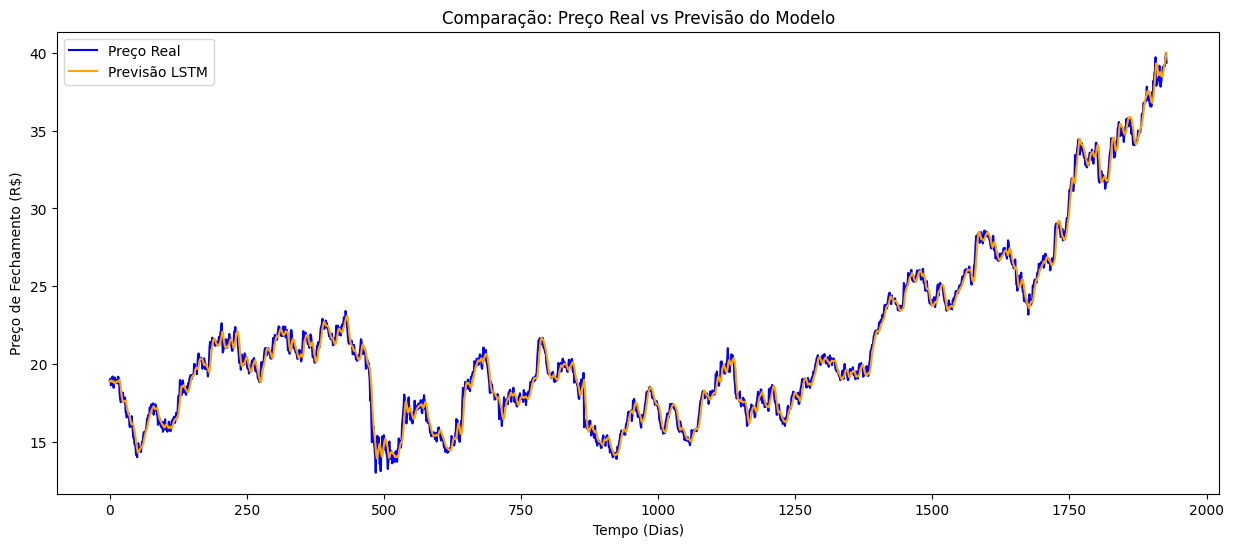

In [0]:
# 1. Fazer as previsões
# 2. Desnormalizar os dados (voltar para o valor original em Reais)
# O scaler foi treinado com os dados originais, então usamos inverse_transform
# 3. Calcular Métricas Exigidas
# 4. Visualização Gráfica

# - Inicio das previsões
# - Desnormalizacoes dos dados para voltar o valor original em reais, para melhor visualizar como o modelo foi treinado com itens reais utilizamos inverse_transform.
# - Calculo das metricas exigidas para a entrega
# - Visualizacao grafica para melhor visualizar as previsões e a proximidade com os valores reais

predictions = model.predict(X)


predictions_rescaled = scaler.inverse_transform(predictions)
y_rescaled = scaler.inverse_transform(y.reshape(-1, 1))


mae = mean_absolute_error(y_rescaled, predictions_rescaled)
rmse = np.sqrt(mean_squared_error(y_rescaled, predictions_rescaled))
mape = np.mean(np.abs((y_rescaled - predictions_rescaled) / y_rescaled)) * 100

print(f"--- Métricas do Modelo ---")
print(f"MAE (Erro Médio Absoluto): R$ {mae:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): R$ {rmse:.2f}")
print(f"MAPE (Erro Percentual Absoluto Médio): {mape:.2f}%")

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_rescaled, label='Preço Real', color='blue')
plt.plot(predictions_rescaled, label='Previsão LSTM', color='orange')
plt.title('Comparação: Preço Real vs Previsão do Modelo')
plt.xlabel('Tempo (Dias)')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.show()

In [0]:
# - Salvando modelo e scaler, necessarios para criacao da API.
model.save('modelo_lstm_itub4.keras')

joblib.dump(scaler, 'scaler_itub4.pkl')

print("Modelo e Scaler salvos com sucesso!")

Modelo e Scaler salvos com sucesso!


In [0]:
# - Salvamento no s3 para poder fazer o download e iniciar o processo da API pelo VScode

bucket_name = "modelo-fechamento-acoes" 
s3 = boto3.client('s3')

s3.upload_file('modelo_lstm_itub4.keras', bucket_name, 'modelos/modelo_lstm_itub4.keras')
s3.upload_file('scaler_itub4.pkl', bucket_name, 'modelos/scaler_itub4.pkl')

print("Arquivos salvos com segurança no S3!")

Arquivos salvos com segurança no S3!


## Shutdown cells

In [0]:
"""
Stop spark session and associated Athena Spark session
"""

from IPython import get_ipython as _get_ipython
_get_ipython().user_ns["spark"].stop()